# **De-noising color image using Autoenncoders**

In [0]:
!pip install torch===0.4.0 torchvision===0.2.1 -f https://download.pytorch.org/whl/torch_stable.html

In [0]:
!pip install "pillow<7"

In [2]:
!mkdir data_faces && wget https://s3-us-west-1.amazonaws.com/udacity-dlnfd/datasets/celeba.zip

--2020-05-22 04:01:13--  https://s3-us-west-1.amazonaws.com/udacity-dlnfd/datasets/celeba.zip
Resolving s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)... 52.219.120.56
Connecting to s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)|52.219.120.56|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1443490838 (1.3G) [application/zip]
Saving to: ‘celeba.zip’

celeba.zip          100%[===================>]   1.34G  21.0MB/s    in 67s     

2020-05-22 04:02:21 (20.4 MB/s) - ‘celeba.zip’ saved [1443490838/1443490838]



In [0]:
import zipfile
with zipfile.ZipFile("celeba.zip","r") as zip_ref:
  zip_ref.extractall("data_faces/")

In [1]:
import os
root = 'data_faces/img_align_celeba'
img_list = os.listdir(root)
print(len(img_list))

202599


In [ ]:
import cv2
root = 'data_faces/img_align_celeba'
img_list = os.listdir(root)
print(img_list[1])

img_t = cv2.imread('data_faces/img_align_celeba/'+img_list[1])
print(img_t.shape)

In [0]:
import torch
import torchvision
from torchvision import transforms
from torchvision import datasets
from torch.utils.data import DataLoader
from skimage.util import random_noise

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
transform = transforms.Compose(
    [transforms.CenterCrop(170),
     transforms.Resize(128),
     transforms.ToTensor(),
     transforms.Normalize(mean=[0.5] * 3, std=[0.5] * 3)])

batch_size = 64
celeba_data = datasets.ImageFolder('./data_faces', transform=transform)
data_loader = DataLoader(celeba_data,batch_size=batch_size,shuffle=True)

In [0]:
def show(img,renorm=False,nrow=8,interpolation='bicubic'):
  if renorm:
    img = img/2 + 0.5
  img_grid = torchvision.utils.make_grid(img,nrow=nrow).numpy()
  plt.figure()
  plt.imshow(np.transpose(img_grid, (1,2,0)), interpolation=interpolation)
  plt.axis('off')
  plt.show()

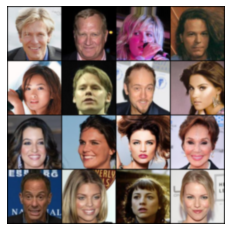

In [22]:
load= iter(data_loader)
batch,_ = load.next()
show(batch[0:16], renorm = True, nrow=4)

In [0]:
import torch.nn as nn
import torch.nn.functional as F

# define the NN architecture
class ConvDenoiser(nn.Module):
    def __init__(self):
        super(ConvDenoiser, self).__init__()
        ## encoder layers ##
        
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)  
        
        self.conv2 = nn.Conv2d(32, 16, 3, padding=1)  
        
        self.conv3 = nn.Conv2d(16, 8, 3, padding=1)
        
        #self.conv4 = nn.Conv2d(16, 8, 3, padding=1)
        # pooling layer to reduce x-y dims by two; kernel and stride of 2
        self.pool = nn.MaxPool2d(2, 2)
        
        ## decoder layers ##
        # transpose layer, a kernel of 2 and a stride of 2 will increase the spatial dims by 2
        self.t_conv1 = nn.ConvTranspose2d(8, 8, 2, stride=2)  # kernel_size=3 to get to a 7x7 image output
        # two more transpose layers with a kernel of 2
        self.t_conv2 = nn.ConvTranspose2d(8, 16, 2, stride=2)
        self.t_conv3 = nn.ConvTranspose2d(16, 32, 2, stride=2)
        
        # one, final, normal conv layer to decrease the depth
        self.conv_out = nn.Conv2d(32, 3, 3, padding=1)


    def forward(self, x):
        ## encode ##
        # add hidden layers with relu activation function
        # and maxpooling after
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        
        # add second hidden layer
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        
        # add third hidden layer
        x = F.relu(self.conv3(x))
        x = self.pool(x) 

        # add fourth hidden layer
        # x = F.relu(self.conv4(x))
        # x = self.pool(x) # compressed representation
        
        ## decode ##
        # add transpose conv layers, with relu activation function
        x = F.relu(self.t_conv1(x))
        x = F.relu(self.t_conv2(x))
        x = F.relu(self.t_conv3(x))
        # x = F.relu(self.t_conv4(x))
        # transpose again, output should have a sigmoid applied
        x = F.relu(self.conv_out(x))
                
        return x


class ConvDenoiserWithBatchNorm(nn.Module):
    def __init__(self):
        super(ConvDenoiserWithBatchNorm, self).__init__()
        ## encoder layers ##
        # conv layer (depth from 3 --> 64), 3x3 kernels
        self.conv1 = nn.Conv2d(3, 64, 3, padding=1)
        self.batch_norm1 = nn.BatchNorm2d(64)  
        # conv layer (depth from 3 --> 32), 3x3 kernels
        self.conv2 = nn.Conv2d(64, 32, 3, padding=1)
        self.batch_norm2 = nn.BatchNorm2d(32)  
        # conv layer (depth from 32 --> 16), 3x3 kernels
        self.conv3 = nn.Conv2d(32, 16, 3, padding=1)
        self.batch_norm3 = nn.BatchNorm2d(16)
        # conv layer (depth from 16 --> 8), 3x3 kernels
        self.conv4 = nn.Conv2d(16, 8, 3, padding=1)
        self.batch_norm4 = nn.BatchNorm2d(8)
        # pooling layer to reduce x-y dims by two; kernel and stride of 2
        self.pool = nn.MaxPool2d(2, 2)
        
        ## decoder layers ##
        # transpose layer, a kernel of 2 and a stride of 2 will increase the spatial dims by 2
        self.t_conv1 = nn.ConvTranspose2d(8, 8, 2, stride=2)  # kernel_size=3 to get to a 7x7 image output
        self.t_batch_norm1 = nn.BatchNorm2d(8)
        # two more transpose layers with a kernel of 2
        self.t_conv2 = nn.ConvTranspose2d(8, 16, 2, stride=2)
        self.t_batch_norm2 = nn.BatchNorm2d(16)
        self.t_conv3 = nn.ConvTranspose2d(16, 32, 2, stride=2)
        self.t_batch_norm3 = nn.BatchNorm2d(32)
        self.t_conv4 = nn.ConvTranspose2d(32, 64, 2, stride=2)
        self.t_batch_norm4 = nn.BatchNorm2d(64)
        # one, final, normal conv layer to decrease the depth
        self.conv_out = nn.Conv2d(64, 3, 3, padding=1)


    def forward(self, x):
        ## encode ##
        # add hidden layers with relu activation function
        # and maxpooling after
        x = F.relu(self.batch_norm1(self.conv1(x)))
        x = self.pool(x)
        
        # add second hidden layer
        x = F.relu(self.batch_norm2(self.conv2(x)))
        x = self.pool(x)
        
        # add third hidden layer
        x = F.relu(self.batch_norm3(self.conv3(x)))
        x = self.pool(x) 

        # add fourth hidden layer
        x = F.relu(self.batch_norm4(self.conv4(x)))
        x = self.pool(x) # compressed representation
        
        ## decode ##
        # add transpose conv layers, with relu activation function
        x = F.relu(self.t_batch_norm1(self.t_conv1(x)))
        x = F.relu(self.t_batch_norm2(self.t_conv2(x)))
        x = F.relu(self.t_batch_norm3(self.t_conv3(x)))
        x = F.relu(self.t_batch_norm4(self.t_conv4(x)))
        # transpose again, output should have a sigmoid applied
        x = F.relu(self.conv_out(x))
                
        return x


In [26]:
# initialize the NN
model = ConvDenoiser()
print(model)

ConvDenoiser(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (t_conv1): ConvTranspose2d(8, 8, kernel_size=(2, 2), stride=(2, 2))
  (t_conv2): ConvTranspose2d(8, 16, kernel_size=(2, 2), stride=(2, 2))
  (t_conv3): ConvTranspose2d(16, 32, kernel_size=(2, 2), stride=(2, 2))
  (conv_out): Conv2d(32, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)


In [27]:
# skip this if running first time
model.load_state_dict(torch.load('trained_models/train-epoch8.pth'))
print(model)

ConvDenoiser(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (t_conv1): ConvTranspose2d(8, 8, kernel_size=(2, 2), stride=(2, 2))
  (t_conv2): ConvTranspose2d(8, 16, kernel_size=(2, 2), stride=(2, 2))
  (t_conv3): ConvTranspose2d(16, 32, kernel_size=(2, 2), stride=(2, 2))
  (conv_out): Conv2d(32, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)


In [0]:
# specify loss function
criterion = nn.MSELoss()
# specify loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [32]:
train_on_gpu = torch.cuda.is_available()

if train_on_gpu:
  model.cuda()
  criterion.cuda()
  print('GPU available for training. Models moved to GPU')
else:
  print('Training on CPU.')

GPU available for training. Models moved to GPU


In [33]:
print(model)

ConvDenoiser(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (t_conv1): ConvTranspose2d(8, 8, kernel_size=(2, 2), stride=(2, 2))
  (t_conv2): ConvTranspose2d(8, 16, kernel_size=(2, 2), stride=(2, 2))
  (t_conv3): ConvTranspose2d(16, 32, kernel_size=(2, 2), stride=(2, 2))
  (conv_out): Conv2d(32, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)


In [ ]:
import time
# number of epochs to train the model
n_epochs = 10

# for adding noise to images
noise_factor=0.3 
losses=[]
prev = 10000
for epoch in range(1, n_epochs+1):
    t0 = time.time()
    # monitor training loss
    train_loss = 0.0
    
    ###################
    # train the model #
    ###################
    for data in data_loader:
        # _ stands in for labels, here
        # no need to flatten images
        
        images, _ = data
        
        ## add random noise to the input images
        noisy_imgs = images + (noise_factor * torch.randn(*images.shape))
        # Clip the images to be between 0 and 1
        noisy_imgs = np.clip(noisy_imgs, 0., 1.)
        
        if train_on_gpu:
            noisy_imgs = noisy_imgs.cuda()
            images = images.cuda()
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        ## forward pass: compute predicted outputs by passing *noisy* images to the model
        outputs = model(noisy_imgs)
        # calculate the loss
        # the "target" is still the original, not-noisy images
        loss = criterion(outputs, images)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update running training loss
        train_loss += loss.item()*images.size(0)
      
    # print avg training statistics 
    train_loss = train_loss/len(data_loader)
    if train_loss < prev:
        torch.save(model.state_dict(), 'exp1-train-epoch{}.pth'.format(epoch))
    losses.append(train_loss)
    prev = min(losses)
    t1 = time.time()    
    print('Epoch: {} \tTraining Loss: {:.6f} \tTime : {:.3f} mins'.format(
        epoch, 
        train_loss,
        ((t1-t0)/60.0)
        ))

In [ ]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T, label='Autoencoder', alpha=0.5)
plt.title("Training Losses")
plt.legend()

In [0]:
iter(data_loader).next()[0].shape


torch.Size([64, 3, 64, 64])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


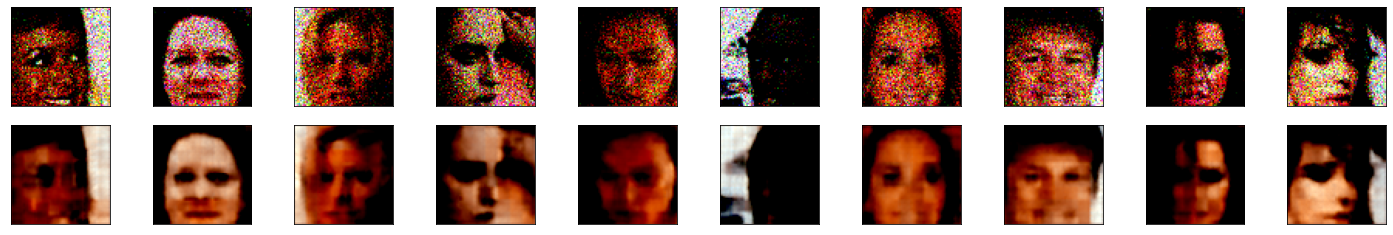

In [0]:
# obtain one batch of test images
dataiter = iter(data_loader)
images, labels = dataiter.next()

# add noise to the test images
noisy_imgs = images + noise_factor * torch.randn(*images.shape)
noisy_imgs = np.clip(noisy_imgs, 0., 1.)

if train_on_gpu:
    noisy_imgs = noisy_imgs.cuda()
    images = images.cuda()

# get sample outputs
output = model(noisy_imgs)
# prep images for display
noisy_imgs = noisy_imgs.cpu().numpy()

# output is resized into a batch of iages
output = output.view(batch_size, 3, 64, 64)
# use detach when it's an output that requires_grad
output = output.detach().cpu().numpy()

# plot the first ten input images and then reconstructed images
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(25,4))

# input images on top row, reconstructions on bottom
for noisy_imgs, row in zip([noisy_imgs, output], axes):
    for img, ax in zip(noisy_imgs, row):
        ax.imshow(np.transpose(img, (1, 2, 0)))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)